# DC2 Coadd Run1.1p GCR access

__Purpose__: This tutorial will illustrate the basics of accessing the merged coadd catalogs through the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader) as well as how to select useful samples of stars/galaxies from the DM outputs.


Note: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

In [ ]:
%pylab inline

## Accessing the coadd catalog with the GCR

The [GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs) package is a DESC project which aims at gathering in one convenient location various simulation/data catalogs made available to the collaboration.  
In this section, we illustrate how to use this tool to access the coadd catalogs from DC2 Run1.1p.

In [ ]:
import GCRCatalogs
# Load the coadd catalog
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

A significant numbers of catalogs besides the DC2 coadd are already available, use `sorted(GCRCatalogs.get_available_catalogs(False))` to see a full list and visit the [DC2 Data Product](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview) page to see all the DC2 related catalogs.

### DC2 Coadd catalog Schema


To see the quantities available in the catalog, you can use the following:

In [ ]:
sorted(catalog.list_all_quantities())

The meaning of these fields is documented in the [SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) file of the `gcr-catalog` repository.  
As explained in that link, the values exposed here are not the native quantities produced by the Data Management stack, but instead this schema strives to follow the standard nomenclature of the LSST Data Products Definition Document [DPDD](http://ls.st/dpdd).

The DPDD is an effort made by the LSST project to standardize the format of the official Data Release Products (DRP). While the native outputs of the DM stack are succeptible to change, the DPDD will be more stable. An early adoption of these conventions by the DESC will save time and energy down the road.

This being said, not all use-cases and relevant quantities are covered by these conventions yet, so the GCR preserves access to the underlying native DM stack fieds, all 2046 of which can be listed using:  

In [ ]:
sorted(catalog.list_all_native_quantities())

We can see that the catalog includes:

* Positions
* Fluxes and magnitudes (PSF and CModel)
* Shapes (using GalSim's HSM)
* Quality flags: e.g, does the source have any interpolated pixels? Has any of the measurement algorithms returned an error?
* Other useful quantities: `blendedness`, measure of how flux is affected by neighbors: (1 - flux.child/flux.parent) (see 4.9.11 of 1705.06766); `extendedness`, classifies sources in extended and psf-like.

### Accessing the data

While run1.1p is still of manageable size, full DC2 will be much larger, accessing the whole data can be challenging. In order to access the data efficiently, it is important to understand how it is physically stored and how to access it, one piece at the time. 


The coadds produced by the DM stack are structured in terms of large `tracts` and smaller `patches`, illustrated here for DC2:
<img src="assets/dc2_skymap.png">
Here the tracts have large blue numbers, and the patches are denoted with an `(x,y)` format. For DC2, each tract has 8x8 patches.

The GCR coadd catalog preserves this structure of the data so that any particular quantity can be accessed on a tract/patch bases. The tracts available in the catalog can be listed using the following command:

In [ ]:
# Query all available tracts and patches, only displays the first 5
catalog.available_tracts_and_patches[:5]

To access a particular part of the data, the GCR provides the following `native_filters` mechanism:


In [ ]:
# Retrieve the ra,dec coordinates of all sources within tract number 4430
data = catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==4430, 'tract')])

# Plot a 2d histogram of sources
figure(figsize=(10,7))
hist2d(data['ra'], data['dec'],100); gca().set_aspect('equal'); colorbar()
xlabel('RA [deg]');
ylabel('dec [deg]');

The data returned by the GCR is structured as a native Python dictionary:

In [ ]:
data

But it can also easily be converted into a Pandas DataFrame, if you are so inclined ;-)

In [ ]:
import pandas
pdata = pandas.DataFrame(data)
pdata

As a simple test, you can show the advantage of loading one tract at a time compared to the entire catalog:

In [ ]:
%time data = catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==4431, 'tract')])

In [ ]:
%time data = catalog.get_quantities(['ra', 'dec'])

In order to make accessing chunks of data convenient to the user, the `catalog.get_quantities` also provides the option to return an iterator:

In [ ]:
# Loop through all the patches of a given tract using an iterator
for d in catalog.get_quantities(['ra', 'dec'],
                                native_filters=[(lambda x: x==4850, 'tract')],
                                return_iterator=True):
    # Here we only handle a small amount of data at a time
    plt.scatter(d['ra'], d['dec'], s=2);
    
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Tract 4850');

### Applying filters and cuts

In order to avoid returning unecessary data, the GCR has a functionality to filter out entries as it reads the files. Note that this is different from the `native_filters` discussed above, which avoids reading part of the data altogether.

Defining these filters requires the `GCRQuery` module of the GCR package and can then be applied during the call to `get_quantities`:

In [ ]:
from GCR import GCRQuery

# Simple cut to remove unreliable detections
# More cuts can be added, as a logical AND, by appending GCRQuerys to this list
simple_cuts = [
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
]

# Loads the data after cut
data_cut = catalog.get_quantities(['ra', 'dec'], 
                              filters = simple_cuts, 
                              native_filters=[(lambda x: x==4849, 'tract')])

# Loads data without cuts
data_full = catalog.get_quantities(['ra', 'dec'], 
                              native_filters=[(lambda x: x==4849, 'tract')])

In [ ]:
# Plot a 2d histogram of sources
figure(figsize=(15,7))
subplot(121)
hist2d(data_full['ra'], data_full['dec'],256); gca().set_aspect('equal'); 
xlabel('RA [deg]');
ylabel('dec [deg]');
title('Full sample')
colorbar()

subplot(122)
hist2d(data_cut['ra'], data_cut['dec'],256); gca().set_aspect('equal');
xlabel('RA [deg]');
ylabel('dec [deg]');
title('Clean objects');
colorbar()

==TODO==: Check this plot I'm a bit confused, I was expecting to see some cosmic rays and stars.... This example turned to be very underwhelming, maybe we should just go directly for star/galaxy separation. JS: I like the example even if the simulated image is boring (Also the number of exposures for a LSST coadd is much larger than the ones for HSC so I guess that will lower the impact of CRs and other defects)

In [ ]:
cat_hsc = GCRCatalogs.load_catalog('hsc-pdr1-xmm')

In [ ]:
# Loads the data after cut
data_cut = cat_hsc.get_quantities(['ra', 'dec'], 
                              filters = simple_cuts)

# Loads data without cuts
data_full = cat_hsc.get_quantities(['ra', 'dec'])

In [ ]:
figure(figsize=(15,7))
subplot(121)
hist2d(data_full['ra'], data_full['dec'],256); gca().set_aspect('equal'); 
xlabel('RA [deg]');
ylabel('dec [deg]');
title('Full sample')

subplot(122)
hist2d(data_cut['ra'], data_cut['dec'],256); gca().set_aspect('equal');
xlabel('RA [deg]');
ylabel('dec [deg]');
title('Clean objects');

## Example of filtering: Star/galaxy separation

For now, we have `extendedness == base_ClassificationExtendedness_value` as a tool for star/galaxy classification. An object is considered extended if the the difference between the `PSF` magnitude and the `CModel` magnitude is beyond certain threshold (0.0164). To know more about this see [Bosch et al. 2017](https://arxiv.org/pdf/1705.06766.pdf) section 4.9.10

In [ ]:
star_cuts = [
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('extendedness==0'),
]

quantities = ['mag_g_cModel', 'mag_r_cModel', 'mag_i_cModel']

d = catalog.get_quantities(quantities, 
                           filters=star_cuts, 
                           native_filters=[(lambda x: x==4849, 'tract')])

So now, we are selected what we think are stars. Let's take a look at the colors of these objects

In [ ]:
plt.hist2d(d['mag_g_cModel']-d['mag_r_cModel'],
           d['mag_r_cModel']-d['mag_i_cModel'], 
           bins=100,range=[(-1,2),(-1,2)]);
plt.xlabel('$g-r$')
plt.ylabel('$r-i$')

You can check what the input stars colors look like [here](https://github.com/LSSTDESC/DC2_Repo/blob/u/yymao/cmu_tutorials/Notebooks/DC2%20Coadd%20Run1.1p%20direct%20access%20--%20color-color%20stellar%20locus.ipynb)

==TODO==: Whenever we have the definitive path to the notebooks, update link!

Q: What else can you do to improve the star selection?

## Selecting a useful sample of galaxies: lensing cuts from HSC DR1

In this section, we will build step by step a sample of galaxies from the DC2 run1.1p coadd catalog, and compare it to an equivalent sample built from the HSC DR1 catalog.

### Sample selection

We will start from a set of basic sanity cuts that will select extended objects and reject problematic sources, including those for which shape measurement has failed.

One subtelty is that shape measurement is only run for the *reference band*, which is most of the time the i-band, but not always, we will further restrict the sample to objects for which we have i-band shapes using the `merge_measurement_i` flag.

==TODO==: Do we need to explain this further? JS: I'd say no, but let's say what our alpha testers think :)

In [ ]:
basic_cuts = [
    GCRQuery('extendedness > 0'),    # Extended objects
    GCRQuery('merge_measurement_i'), # Select objects for which the reference is the i-band
    
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    ~GCRQuery('xy_flag'),                                       # Flag for bad centroid measurement
    ~GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),             # Error code returned by shape measurement code
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_sigma')) # Shape measurement uncertainty should not be NaN
]

In addition to these basic cuts, we will want to apply a set of cuts based on object properties, to ensure we are selecting well resolved and well measured galaxies. One of these properties is the measured total distortion, which is not directly defined in the schema, but can be derived from the measured $e1$, $e2$ distortion components according to $|e| = \sqrt{e_1^2 + e_2^2 }$

The GCR provides a convenience function, `add_quantity_modifier`, to add this quantity to the schema on the fly, so that we can use it afterwards to build our cuts:

In [ ]:
# Adds the new derived column 
catalog.add_quantity_modifier('shape_hsm_regauss_etot', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)

# Define lensing cuts on galaxy properties 
properties_cuts = [
    GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
    GCRQuery('mag_i_cModel < 24.5'),                            # cModel imag brighter than 24.5
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'), # Sufficiently resolved galaxies compared to PSF
    GCRQuery('shape_hsm_regauss_etot < 2'),                     # Total distortion in reasonable range
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4')       # Shape measurement errors reasonable
]

# We can now extract our lensing sample 
quantities = ['mag_i_cModel', 'snr_i_cModel', 'shape_hsm_regauss_etot', 'ext_shapeHSM_HsmShapeRegauss_resolution']
data = catalog.get_quantities(quantities, 
                           filters=basic_cuts + properties_cuts, 
                           native_filters=[(lambda x: x==4849, 'tract')])

In [ ]:
figure(figsize=(10,10))
subplot(221)
hist(data['ext_shapeHSM_HsmShapeRegauss_resolution'], 100, range=[0,1],normed=True);
xlabel('i-band resolution')
xlim()
subplot(222)
hist(data['snr_i_cModel'], 100, range=[0,100],normed=True)
xlabel('i-band cmodel S/N')
subplot(223)
hist(data['mag_i_cModel'], 100, range=[20,25],normed=True);
xlabel('i-band cmodel mag')
subplot(224)
hist(data['shape_hsm_regauss_etot'],100,normed=True);
xlabel('Ellipticity magniture |e|');

You can compare this plot to Fig 12. in [Mandelbaum et al. 2017](https://arxiv.org/pdf/1705.06745.pdf):
<img src="assets/fig12_mandelbaum2017.png">

A quick visual comparison will highlight two things:

  - We are missing a lot of galaxies between 23 and 24.5 mag
  - We have a bump near resolution of 1

We are going to investigate to understand these differences below.

### Looking at the depth of the survey

One obvious reason why we would be missing some faint galaxies is if DC2 run1.1p is shallower than HSC. We will test this here by measuring the depths of both run 1.1p and the HSC DR1 XMM field. More generally, it is also a concern for most science analysis to have spatially uniform sampled data, which can be checked by looking at the depth of the sample.  

There are several ways to do this, in this case, we are going to check what's the magnitude which has a median SNR closest to 10, the SNR cut of our lensing sample.

In [ ]:
import healpy as hp
from cic import binned_statistic  # Import and efficient alternative to binned_statistic_2d, defined in cic.py

def depth_map_snr (ra, dec, mags, snr,snr_threshold=10,nside=2048):
    """
    Constructs a depth map on a healpix grid for a given SNR threshold.
    
    Parameters
    ----------
    ra, dec: Array of coordinates on the sky (in deg.)
    mags, snr : measured magnitude and snr for the sample
    snr_threshold: SNR
    """
    # Remove potentially problematic entries
    good = np.logical_or(np.logical_not(np.isnan(ra)),np.logical_not(np.isnan(dec)))
    # Create array of healpix pixel indices corresponding to coordinates 
    pix_nums = hp.ang2pix(nside,np.pi/2.-dec[good]*np.pi/180,ra[good]*np.pi/180)
    
    # Create output map
    map_out = np.zeros(12*nside**2)
    
    # Bins in magnitudes
    bin_centers = np.linspace(22+6/30.,28-6/30.,30.)
    
    # For each healpix pixel
    for px in np.unique(pix_nums):
        # Select all objects within this pixel
        mask = px==pix_nums
        if np.count_nonzero(mask)>0:
            # Compute median snr in bins of magnitude
            median_snr = binned_statistic(mags[mask],snr[mask],np.nanmedian,nbins=30,range=(22,28))
            mask2 = np.isnan(median_snr)==False
            # Find magnitude corresponding to snr threshold
            if np.count_nonzero(mask2)>0:
                depth = bin_centers[mask2][np.argmin(np.fabs(median_snr[mask2] - snr_threshold))]
                map_out[px]=depth
            else:
                map_out[px]=0
        else:
            map_out[px]=0.
    return map_out

In [ ]:
quantities = ['ra', 'dec', 'mag_i_cModel', 'snr_i_cModel', 'ext_shapeHSM_HsmShapeRegauss_resolution']

# Data from DC2 run1.1p
data_dc2 = catalog.get_quantities(quantities, 
                                  filters=basic_cuts, # Note the only apply the basic_cuts
                                  native_filters=[(lambda x: x==4849, 'tract')])

# Data from HSC DR1 XMM field 
cat_hsc = GCRCatalogs.load_catalog('hsc-pdr1-xmm')
data_hsc = cat_hsc.get_quantities(quantities,
                                  filters=basic_cuts)

In [ ]:
# Compute i-band depth maps for both surveys
m10map_dc2 = depth_map_snr(data_dc2['ra'],data_dc2['dec'],data_dc2['mag_i_cModel'], data_dc2['snr_i_cModel'])
m10map_hsc = depth_map_snr(data_hsc['ra'],data_hsc['dec'],data_hsc['mag_i_cModel'], data_hsc['snr_i_cModel'])

# Printing the median depth
print("Run1.1p median i-band 10-sigma depth ", median(m10map_dc2[m10map_dc2 > 0]))
print("HSC XMM median i-band 10-sigma depth ", median(m10map_hsc[m10map_hsc > 0]))

And now we see the difference between the two samples, HSC is much deeper. This is partly due to the fact that run1.1p was interrupted mid-run so it doesn't reach the full depth of DC2.

In [ ]:
# Let's visually compare the 2 depth maps
hp.gnomview(m10map_dc2,rot=(data_dc2['ra'].mean(), data_dc2['dec'].mean()), title='Run 1.1 Depth', reso=0.5,unit='10-$\sigma$ i-band depth',min=22, max=27.)
hp.gnomview(m10map_hsc,rot=(data_hsc['ra'].mean(), data_hsc['dec'].mean()), title='HSC DR1 XMM Depth', reso=0.5,unit='10-$\sigma$ i-band depth',min=22, max=27.)

### Impact of blendedness
 
The second discrepancy between our sample and the Mandelbaum et al. plot is an excess of galaxies appearing very well resolved compared to the PSF (resolution > 0.9). To understand this difference, we are going to select a few of these objects and extract postage stamps from the DM stack for visual inspection.

We begin by selecting galaxies in our lensing sample which are near perfectly resolved by adding a cut on resolution:

In [ ]:
sample_cut = basic_cuts + properties_cuts + [GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.98')]

data = catalog.get_quantities(['ra', 'dec', 'mag_i_cModel', 'ext_shapeHSM_HsmShapeRegauss_resolution'], 
                              filters=sample_cut,
                              native_filters=[(lambda x: x==4849, 'tract')])

Now we will extract a few postage stamps at these coordinates, to do so we will reuse some of the code from the [DC2 Postage Stamps tutorial](/DC2%20Postage%20Stamps.ipynb). Please have a look a this tutorial to understand the function we will be using here, but in a nustshell we are going to query the DM data Butler to retrieve cutouts of the Deep Coadd exposures of these objects in the i-band.

In [ ]:
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay

from astropy.table import Table
from astropy.visualization import ZScaleInterval

# Please check the DC2 Postage Stamps tutorial for all the details of how this works
def cutout_coadd_ra_dec(butler, ra, dec, filt='i', datasetType='deepCoadd', 
                                  skymap=None, cutoutSideLength=50, **kwargs):
    """Produce a cutout from a coadd at the given ra,dec coordinates
    

    Parameters
    --
    butler - lsst.daf.persistence.Butler of the data repository
    ra, dec - coordinates of the center of the cutout (in degrees).
    filter - Filter of the image to load
    datasetType - 'deepCoadd'  Which type of coadd to load.  Doesn't support 'calexp'
    
    skymap - [optional] Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength - [optional] Side of the cutout region in pixels.
    
    Returns
    --
    MaskedImage
    """
    # Create a lsst.afw.geom.SpherePoint coordinates object
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("deepCoadd_skyMap")
    
    # Retrieves the tract, patch info for these coordinates from the skymap
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    
    # Get pixel coordinates on the tract
    xy = afwGeom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)

    coaddId = {'tract': tractInfo.getId(), 'patch': "%d,%d" % patchInfo.getIndex(), 'filter': filt}
    
    cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
    
    return cutout_image

With this tool to extract cutouts in hand, let's have a look at a few examples in our sample:

In [ ]:
# Create an instance of the data butler for the run 1.1p data repository
repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output'
butler = dafPersist.Butler(repo)

figure(figsize=(15,15));
for i in range(16):
    subplot(4,4,i+1)

    # Extract the cutout using the data butler
    cutout_image = cutout_coadd_ra_dec(butler, data['ra'][i], data['dec'][i]);
    
    # Plot the postage stamp on the same scales, with some arcsinh range compression 
    imshow(arcsinh(cutout_image.image.array), vmax=4, cmap='binary');
    
    # Let's add a crosshair to guide the eye
    axhline(25, color='k',alpha=0.5)
    axvline(25, color='k',alpha=0.5);

So, one thing may jump to eye, these objects are supposed to be large, extremely well resolved, yet they often look fairly small... but they have a lot of sometimes very bright neighbours. This is very suspicious and may indicate a problem with the DM deblender.

Looking at the [SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) one may notice a field named `blendedness`. This is a metric produced by the DM stack defined  for deblended objects and "measures the fraction of the total flux in the neighborhood of a source that belongs to its neighbors" [(Bosch et. 2017)](https://arxiv.org/pdf/1705.06766.pdf).

Let's have a look at the `blendedness` values of the examples in our sample:

In [ ]:
data = catalog.get_quantities(['blendedness'], 
                              filters=sample_cut,
                              native_filters=[(lambda x: x==4849, 'tract')])

data['blendedness'][0:16]

As one would expect, they all have a large values, close to 1, indicating that these objects belong to very blended neighborhoods. Because the deblender seems to be failing for these objects, we can use this metric to try to exclude them from our sample. 

As a matter of fact, this is what was done in the (Mandelbaum et al., 2017) paper where an additional cut on blendedness was introduced to guard against deblender failures. 

Let's try to rebuild our sample following the same approach:

In [ ]:
properties_cuts = [
    GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
    GCRQuery('mag_i_cModel < 24.5'),                            # cModel imag brighter than 24.5
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'), # Sufficiently resolved galaxies compared to PSF
    GCRQuery('shape_hsm_regauss_etot < 2'),                     # Total distortion in reasonable range
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),      # Shape measurement errors reasonable
    # New cut on blendedness:
    GCRQuery('blendedness < 10**(-0.375)')                      # Avoid spurious detections and those contaminated by blends
]

quantities = ['mag_i_cModel', 'snr_i_cModel', 'shape_hsm_regauss_etot', 'ext_shapeHSM_HsmShapeRegauss_resolution']
data = catalog.get_quantities(quantities, 
                           filters=basic_cuts + properties_cuts, 
                           native_filters=[(lambda x: x==4849, 'tract')])

In [ ]:
figure(figsize=(10,10))
subplot(221)
hist(data['ext_shapeHSM_HsmShapeRegauss_resolution'], 100, range=[0,1],normed=True);
xlabel('i-band resolution')
xlim()
subplot(222)
hist(data['snr_i_cModel'], 100, range=[0,100],normed=True)
xlabel('i-band cmodel S/N')
subplot(223)
hist(data['mag_i_cModel'], 100, range=[20,25],normed=True);
xlabel('i-band cmodel mag')
subplot(224)
hist(data['shape_hsm_regauss_etot'],100,normed=True);
xlabel('Ellipticity magniture |e|');

\o/ The excess of high resolution objects has disappeared, mystery solved!

## Challenge: Galaxy counts-in-cells

Blending affects the accuracy of centroid and flux measurements. It can potentially generate a systematic effect in different measurements (for example 2-point statistics). 

The stack, returns a very useful value to check (partially) for the presence of these kind of systematics, which is the `blendedness` parameter (more details on Section 4.9.11 of [Bosch et al. 2017](https://arxiv.org/pdf/1705.06766.pdf)

* Q: Why partially?


A very simple tool to measure the different statistical moments of galaxies is Counts-in-cells (CiC) [Peebles et al. 1980](https://press.princeton.edu/titles/724.html). Here, we are going to use a simplified version of CiC to check the possible systematic effects due to differences in the `blendedness` measurements.

So what's CiC?

1) Count the number of galaxies in a cell of a given scale.

2) Measure the density contrast distribution and its moments.

3) Change the scale and repeat.

In [ ]:
from cic import cic_analysis

In [ ]:
import healpy as hp

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
# Let's use almost the same cuts as in the WL sample
tract_number = 4849
cic_cuts_nb = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness < 10**(-0.375)'),
]

cic_cuts_b = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness > 10**(-0.375)'),
]

quantities = ['ra','dec']
d_nb = catalog.get_quantities(quantities, 
                           filters=cic_cuts_nb, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])
d_b = catalog.get_quantities(quantities, 
                           filters=cic_cuts_b, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

In [ ]:
mask = np.zeros_like(m5map)
mask[m5map>23.0] = 1.0

In [ ]:
hp.gnomview(mask,rot=(data['ra'].mean(), data['dec'].mean()), title='Run 1.1 Depth', reso=0.5,unit='10-$\sigma$ i-band depth')

In [ ]:
sigma_b, sigma_err_b, skw_b, skw_err_b, kurtosis_b, kurtosis_err_b, pixel_scale = cic_analysis(d_b, mask, nboot=100)
sigma_nb, sigma_err_nb, skw_nb, skw_err_nb, kurtosis_nb, kurtosis_err_nb, _  = cic_analysis(d_nb, mask, nboot=100)
#TODO: Include CiC with shapes?

In [ ]:
f, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].errorbar(pixel_scale, sigma_b, sigma_err_b, fmt='o', linestyle='none', label='High blendedness')
ax[0].errorbar(pixel_scale, sigma_nb, sigma_err_nb, fmt='x', linestyle='none', label='Low blendedness')
ax[0].legend()
ax[0].set_xlabel('Pixel scale [deg]')
ax[0].set_ylabel(r'$\sigma$')
ax[1].errorbar(pixel_scale, skw_b, skw_err_b, fmt='o', linestyle='none', label='High blendedness')
ax[1].errorbar(pixel_scale, skw_nb, skw_err_nb, fmt='x', linestyle='none', label='Low blendedness')
ax[1].legend()
ax[1].set_xlabel('Pixel scale [deg]')
ax[1].set_ylabel(r'$S_{3}$')
ax[2].errorbar(pixel_scale, kurtosis_b, kurtosis_err_b, fmt='o', linestyle='none', label='High blendedness')
ax[2].errorbar(pixel_scale, kurtosis_nb, kurtosis_err_nb, fmt='x', linestyle='none', label='Low blendedness')
ax[2].legend()
ax[2].set_xlabel('Pixel scale [deg]')
ax[2].set_ylabel(r'$S_{4}$')

There's definitely something going on with the high blendedness sources!

## Challenge: Check if PSF residuals are within requirements

In this section, we will try to apply all the tools we have covered during this tutorial to test the quality of the DM stack PSF model on run 1.1p.

The challenge will be to select a clean sample of stars, compute their size and ellipticity using second moments, and compare those to the PSF model predicted by the DM stack. We will test the one point and two point fuctions of these residuals to make diagnostic plots that would directly go into a weak lensing shape catalog paper.

==TODO==: A few words about second moments ?

### Step 1: Select a clean sample of point sources

We want to restrict our sample to objects that follow these constraints:
 - Point sources
 - Not corrupted or with any defects
 - Successful second moment measurements
 - Sufficiently high signal to noise in the i-band, above 50
 
Remember to use [SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) as a reference to build your cuts

In [92]:
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

filters=[
    #### This would be removed in the tutorial notebook
         GCRQuery('extendedness == 0'),
         GCRQuery('clean'), 
         GCRQuery('blendedness < 10**(-0.375)'),
        ~GCRQuery('I_flag'),
         GCRQuery('i_SNR > 21')
    ####
]

### Step 2: Computes size and ellipticity from second moments

We will use the following definitions:  
$g_1 = \frac{I_{xx} - I_{yy}}{I_{xx} + I_{yy}}$  
$g_2 = \frac{2 I_{xy}}{I_{xx} + I_{yy}}$  
$\sigma = ( I_{xx} I_{yy} - I_{xy}^2)^{1/4}$ 

Using the `add_modifier_on_derived_quantities` of the GCR (documented [here](https://yymao.github.io/generic-catalog-reader/index.html#GCR.BaseGenericCatalog.add_modifier_on_derived_quantities)), add modifiers to compute these quantities for the sources and the PSF model evaluated at the position of the sources.
Again the schema is your friend ;-)

In [98]:
# This would be hiddden #$####
g1_modif = lambda ixx,iyy,ixy: (ixx-iyy)/(ixx+iyy)
g2_modif = lambda ixx,iyy,ixy:  2.*ixy/(ixx+iyy)
sigma_modif = lambda ixx,iyy,ixy: (ixx*iyy - ixy**2)**0.25
#######

# Here is a template to fill for g1
catalog.add_modifier_on_derived_quantities('g1',
                                           #### This would be removed in the tutorial
                                           g1_modif, 
                                           'Ixx', 'Iyy', 'Ixy'
                                           ########
                                          )
# Define in the same way g2, sigma, psf_g1, psf_g2 psf_sigma

### The following would be hidden
catalog.add_modifier_on_derived_quantities('g2', g2_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_modifier_on_derived_quantities('sigma', sigma_modif, 'Ixx', 'Iyy', 'Ixy')

catalog.add_modifier_on_derived_quantities('psf_g1', g1_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_g2', g2_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_sigma', sigma_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')

### Step 3: Extract sample

Now that we have all the pieces, let's extract the quantities specified below from the catalog:

In [99]:
quantities = ['ra', 'dec', 
              'mag_i', 'i_SNR', 'psf_fwhm_i',
              'g1', 'g2', 'sigma',
              'psf_g1', 'psf_g2', 'psf_sigma']

# Would be hidden
data = catalog.get_quantities(quantities, 
                              native_filters=[(lambda x: x==4850, 'tract')],
                              filters=filters)

### Step 4: Size and ellipticity residuals as a function of magnitude and seeing

Try to reproduce plots similar to the ones you can find in the PSF section of your favorite experiment's shape catalog paper (for instance Section 4. of [Mandelbaum et al. 2017](https://arxiv.org/pdf/1705.06745.pdf)).

For instance you can look at the fractional difference in size, as a function of magnitude, or seeing. You can also look at the distribution of ellipticity residuals, make sure they are centered on 0 , and again see if you can spot a dependence on seeing or magnitude.

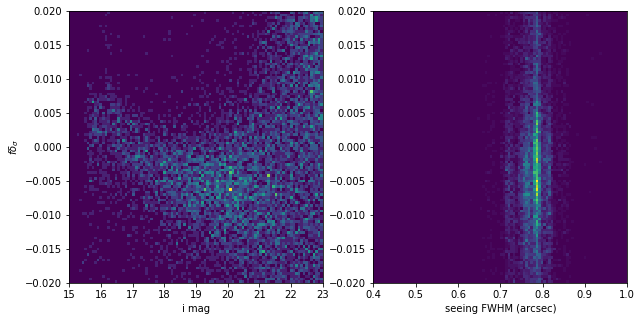

In [100]:
figure(figsize=(10,5))

subplot(121)
hist2d(data['mag_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[15,23],[-0.02,0.02]]);
xlabel('i mag')
ylabel('$f \delta_\sigma$')
subplot(122)
hist2d(data['psf_fwhm_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[0.4,1.0],[-0.02,0.02]]);
xlabel('seeing FWHM (arcsec)')

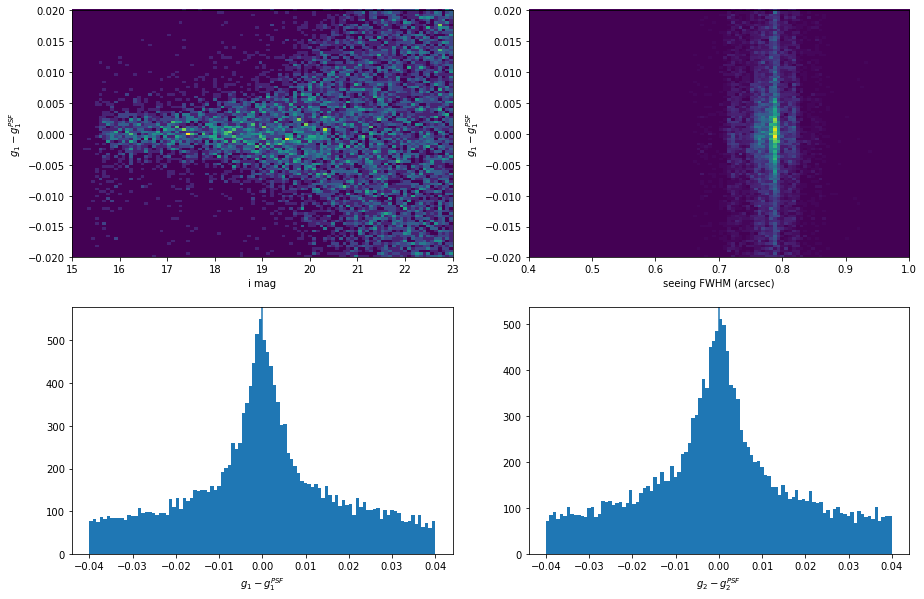

In [101]:
figure(figsize=(15,10))

subplot(221)
hist2d(data['mag_i'], (data['g1'] - data['psf_g1']), 100, range=[[15,23],[-0.02,0.02]]);
xlabel('i mag')
ylabel('$g_1 - g_1^{PSF}$')
subplot(222)
hist2d(data['psf_fwhm_i'], (data['g1'] - data['psf_g1']), 100, range=[[0.4,1.0],[-0.02,0.02]]);
xlabel('seeing FWHM (arcsec)')
ylabel('$g_1 - g_1^{PSF}$')

subplot(223)
hist((data['g1'] - data['psf_g1']), 100, range=[-0.04,0.04]);
xlabel('$g_1 - g_1^{PSF}$')
axvline(0)
subplot(224)
hist((data['g2'] - data['psf_g2']), 100, range=[-0.04,0.04]);
xlabel('$g_2 - g_2^{PSF}$')
axvline(0)

### Step 5: Compute $\rho$-statistics in Stile

No shear catalog paper would be complete without the so-called $\rho$-statistics (Rowe, Jarvis), which check the two-point correlations of the PSF residuals.

==TODO==: Add more details and proper reference !


We are going to use the [Stile](https://github.com/msimet/Stile) package developed by Melanie Simet [@msimet](https://github.com/msimet), an incredibly useful package which already implements a range of WL related systematics tests, including the $\rho$ statistics. Checkout the documentation for Stile [here](http://stile.readthedocs.io/en/latest/index.html).

In [103]:
import pandas
import stile

# Stile expects numpy structured arrays, here is an easy way to do that:
d = pandas.DataFrame(data)
# We also add a weight column, set to 1
d['w'] =1
d = d.to_records(index=False)

In [104]:
# Here is an example of how to compute the rho1 statistics
stile_args = {'ra_units': 'degrees', 'dec_units': 'degrees',
              'min_sep': 0.05, 'max_sep': 1, 'sep_units': 'degrees', 'nbins': 20}

rho1 = stile.CorrelationFunctionSysTest('Rho1')

r1 = rho1(d, config=stile_args)

In [106]:
# Have a look at the content of the result array
r1

array([ ( 0.053888,  0.054138, -2.9172  ,  -6.86960000e-06,  -1.12120000e-05,   8.44320000e-06,   2.83490000e-06,   7.28750000e-06,    476870.,    476870.),
       ( 0.062596,  0.062872, -2.7676  ,   9.22840000e-06,   1.05170000e-05,  -6.17390000e-06,  -9.94910000e-06,   6.30810000e-06,    636450.,    636450.),
       ( 0.072711,  0.073027, -2.6179  ,   5.87670000e-06,   3.14390000e-06,   6.04370000e-06,  -6.23720000e-06,   5.48250000e-06,    842570.,    842570.),
       ( 0.08446 ,  0.084835, -2.468   ,  -1.98500000e-06,   1.52450000e-06,   3.99510000e-06,  -3.77170000e-06,   4.75960000e-06,   1118000.,   1118000.),
       ( 0.098107,  0.098529, -2.3183  ,   3.49930000e-06,  -5.00390000e-06,   1.02920000e-06,  -6.89440000e-06,   4.13280000e-06,   1482700.,   1482700.),
       ( 0.11396 ,  0.11446 , -2.1684  ,  -2.84450000e-06,  -5.12910000e-06,   3.55620000e-06,   5.21860000e-06,   3.59880000e-06,   1955400.,   1955400.),
       ( 0.13237 ,  0.13295 , -2.0187  ,   1.43890000e-06,   4.

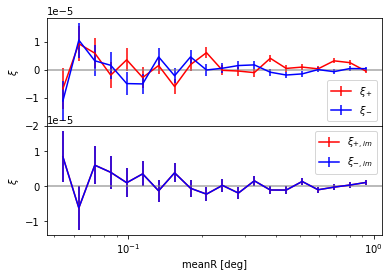

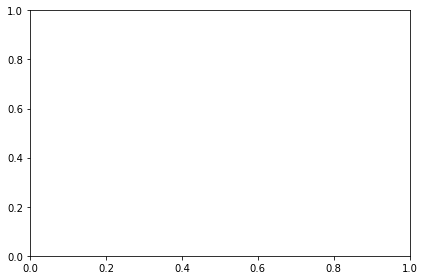

In [105]:
# Stile offers utility functions to generate 
f = rho1.plot(r1);

In [ ]:
rho1 = stile.CorrelationFunctionSysTest('Rho1')
rho2 = stile.CorrelationFunctionSysTest('Rho2')

r1 = rho1(d, config=stile_args)
r2 = rho2(d, config=stile_args)

In [ ]:
f = rho2.plot(r2);